# Dense Neural Network

* Here we are dealing with the most basic neural network. 
The network contains two hidden Dense Neural Networks.

* We use Standard Scaling for input(X) and Mean-Max Scaling for output(Y). Tanh is used as the output activation function. 

* 12th label parameter (one of the Dihedral angles) had some issues which is fixed. 

* IQR method is used to remove outliers.


# Data Augmentation using FFT
I was experimenting with the data by taking its fourier transform to see if it captures the labels better than its original counterpart. 

In [1]:
import numpy as np # linear algebra
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import time
%matplotlib inline
from sklearn.model_selection import train_test_split
import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Output_data_ML.npy')

In [0]:
X=np.roll(np.fft.fft(X,axis=1),19,axis=1)

In [80]:
Y=Y.T
print(np.shape(X),np.shape(Y))

'''
#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
X=(X-x_mean)/x_std
'''

Y[Y[:,11]>2*np.pi,11]=Y[Y[:,11]>2*np.pi,11]-2*np.pi
Y[Y[:,11]<0,11]=Y[Y[:,11]<0,11]+2*np.pi
#Output[:,12:]=Output[:,12:]+2.0*np.pi

#Y=np.log(Y)
R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R,:]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]

#Tanh Scaling of Y
y_mean=np.mean(Y,axis=0)
Y=Y-y_mean
y_mean=np.mean(Y,axis=0)
Y=Y-y_mean
y_max=np.max(np.abs(Y),axis=0)
Y=Y/y_max

'''
#Min_Max Scaling of Y
y_min=np.min(Y,axis=0)
Y=Y-y_min
y_max=np.max(Y,axis=0)
Y=Y/y_max
'''
X=np.reshape(X,(-1,38,1))

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.1)
print(np.shape(xtrain),np.shape(ytrain),np.shape(xtest),np.shape(ytest))

(1070107, 38) (1070107, 15)
(933228, 38, 1) (933228, 15) (103692, 38, 1) (103692, 15)


In [81]:
print(x_mean,x_std)
np.round(np.mean(Y,axis=0),3)

-0.004383674343281866 0.00966049280916536


array([-0., -0.,  0., -0.,  0.,  0., -0., -0.,  0., -0.,  0., -0., -0.,
       -0.,  0.], dtype=float32)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


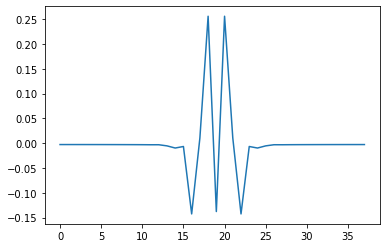

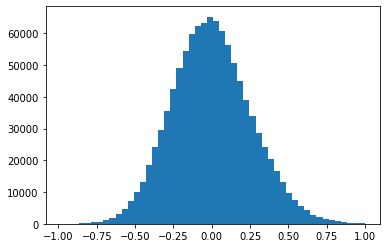

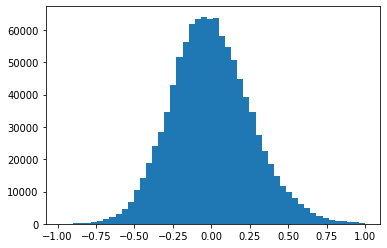

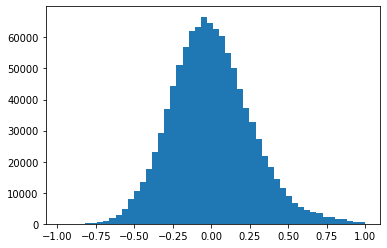

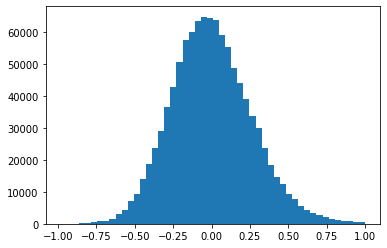

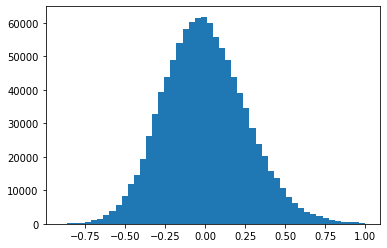

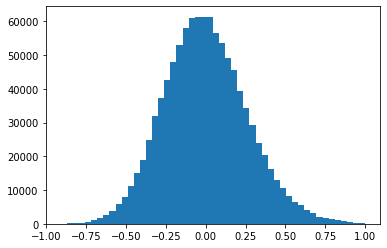

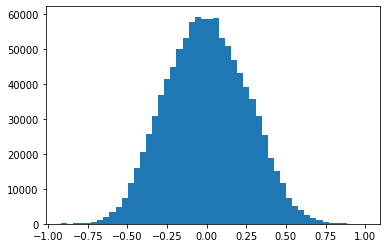

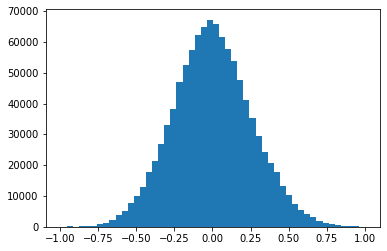

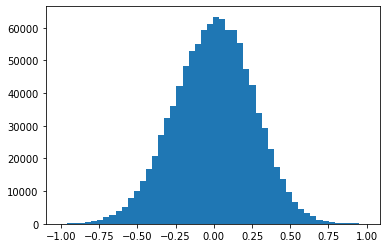

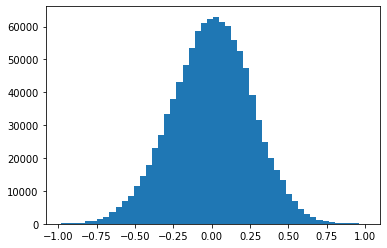

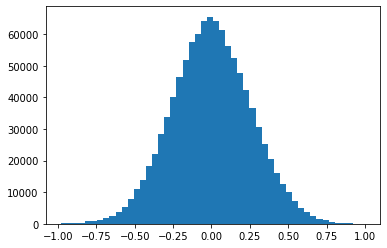

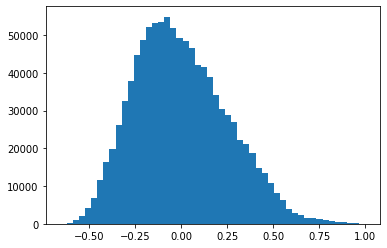

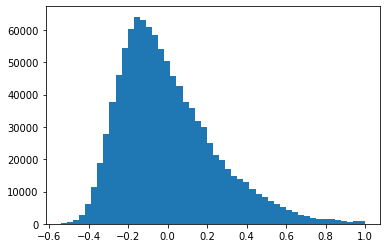

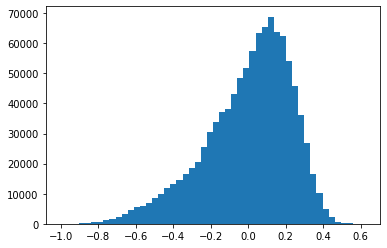

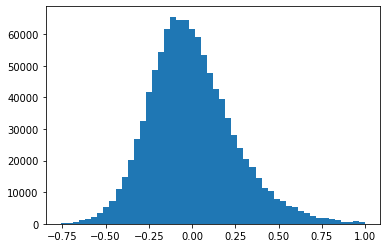

In [82]:
plt.plot(X[10000,:])
plt.show()
for i in range(15):
    plt.hist(Y[:,i],bins=50)
    plt.show()

In [83]:
model = Sequential()

'''
model.add(Conv1D(filters = 30, kernel_size = 5, activation='relu', input_shape = (38,1)))
#model.add(BatchNormalization())
model.add(Conv1D(filters = 60, kernel_size = 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 16, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool1D(strides=2))
model.add(Dropout(0.25))

#model.add(Conv1D(filters = 60, kernel_size = 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 60, kernel_size = 5, activation='relu'))
#model.add(BatchNormalization())
#model.add(Conv1D(filters = 32, kernel_size = 3, activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool1D(strides=2))
#model.add(Dropout(0.25))
'''

model.add(Flatten(input_shape=(38,1)))
model.add(Dense(760, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(300, activation='linear'))
model.add(LeakyReLU(alpha=.1))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(15, activation='tanh'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 38)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 760)               29640     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 760)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 760)               3040      
_________________________________________________________________
dropout_9 (Dropout)          (None, 760)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 300)               228300    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 300)              

In [84]:
model.compile(loss='mse', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

hist = model.fit(x=xtrain, y=ytrain, batch_size=512,
                           epochs=10, #Increase this when not on Kaggle kernel
                           verbose=1,  #1 for ETA, 0 for silent
                           validation_data=(xtest, ytest), #For speed
                           callbacks=[annealer])

Train on 933228 samples, validate on 103692 samples
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


933228/933228 [==============================] - 60s 64us/step - loss: 0.0632 - accuracy: 0.2424 - val_loss: 0.0393 - val_accuracy: 0.2984
Epoch 2/10
933228/933228 [==============================] - 59s 63us/step - loss: 0.0387 - accuracy: 0.3076 - val_loss: 0.0364 - val_accuracy: 0.3253
Epoch 3/10
933228/933228 [==============================] - 60s 64us/step - loss: 0.0372 - accuracy: 0.3228 - val_loss: 0.0353 - val_accuracy: 0.3388
Epoch 4/10
933228/933228 [==============================] - 60s 64us/step - loss: 0.0366 - accuracy: 0.3296 - val_loss: 0.0349 - val_accuracy: 0.3397
Epoch 5/10
933228/933228 [==============================] - 64s 69us/step - loss: 0.0361 - accuracy: 0.3330 - val_loss: 0.0346 - val_accuracy: 0.3419
Epoch 6/10
933228/933228 [==============================] - 61s 65us/step - loss: 0.0359 - accuracy: 0.3367 - val_loss: 0.0344 - val_accuracy: 0.3520
Epoch 7/10
933228/933228 [==============================] - 61s 65us/step - loss: 0.0356 - accuracy: 0.3391 - v

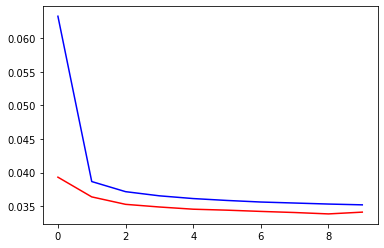

In [85]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

In [86]:
Y_hat=model.predict(X)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/constant_op.py:96: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


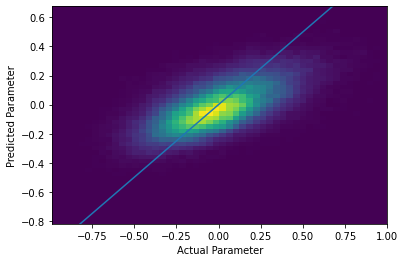

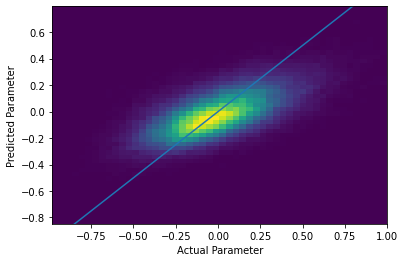

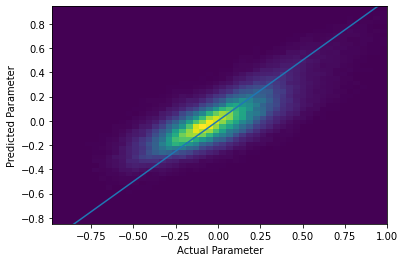

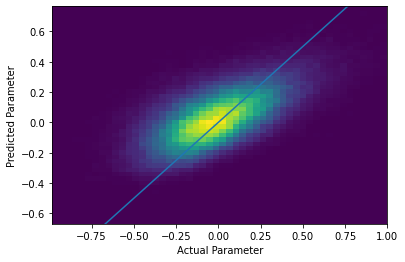

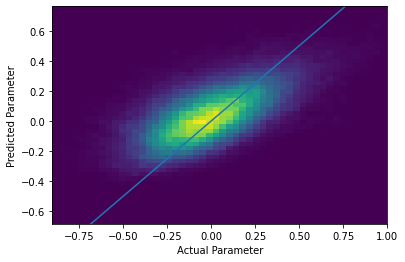

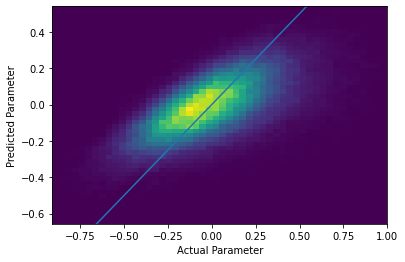

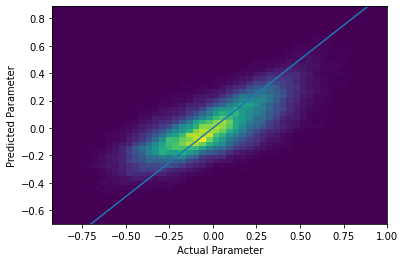

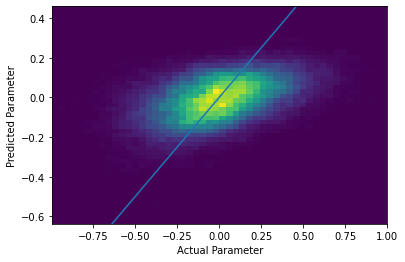

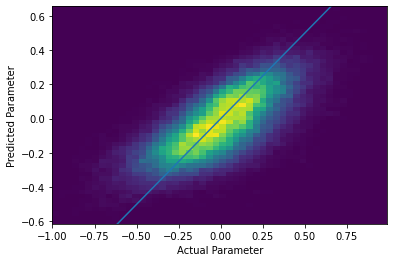

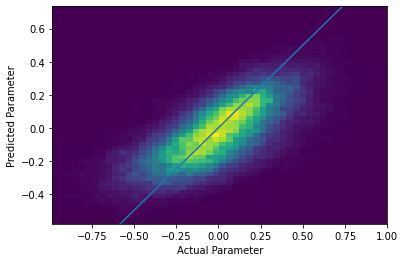

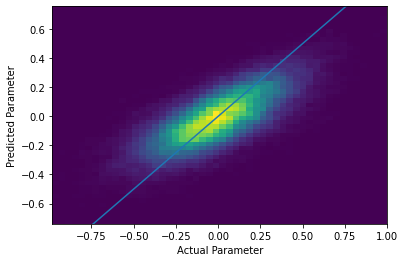

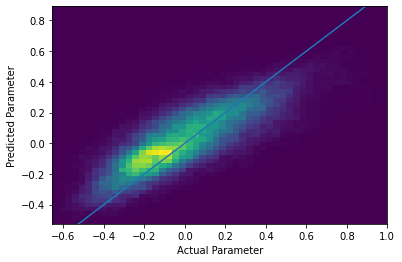

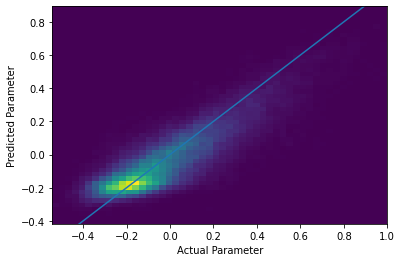

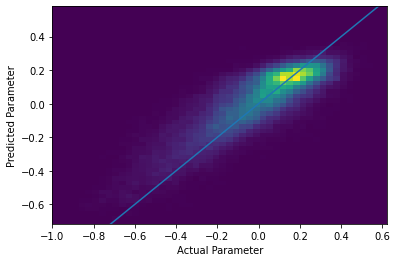

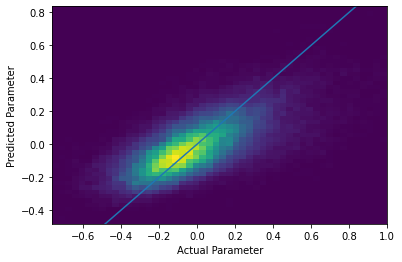

In [87]:
for i in range(15):
  plt.hist2d(Y[:,i],Y_hat[:,i],bins=50)
  plt.xlabel('Actual Parameter')
  plt.ylabel('Predicted Parameter')
  plt.plot(np.arange(-1,1,0.01),np.arange(-1,1,0.01))
  plt.show()